<h1 style="color:#D40078; font-weight:bold;">Genetic:</h1>  
<span style="color:blue"> In this project, we use a genetic algorithm to generate an image made of triangles that closely resembles the original image. </span>


In [2]:
import random
from PIL import Image, ImageDraw
import numpy as np
import cv2
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math
import copy
from copy import deepcopy

<span style="color: #D40078;"> **Gene:** </span>  
<span style="color: blue"> Here, our genes are triangles. Each triangle is created using the Triangle class, which gives them random colors and an alpha value. The alpha value controls the transparency of the triangle, where 0 is fully transparent and 1 is fully opaque. </span>  

<span style="color: #D40078;"> **Chromosomes:** </span>  
<span style="color: blue"> Each chromosome is made up of multiple triangles, which together form an image. </span>  

<span style="color: #D40078;"> **Population:** </span>  
<span style="color: blue"> Our population is a group of chromosomes. We work with populations of different sizes: 50, 80, and 100 chromosomes, and compare how each population size performs. </span>  

<span style="color: #D40078;"> **Fitness function**: </span>  
<span style="color: blue"> There are several methods to compare the similarity between two images:  </span>  
<span style="color: blue"> 1. **Mean Squared Error (MSE):** This calculates the average squared difference between the pixels of two images. A lower value means the images are more similar.  </span>  
<span style="color: blue"> 2. **Mean Absolute Error (MAE):** This calculates the average absolute difference between the pixels of two images.  </span>  
<span style="color: blue"> 3. **Structural Similarity (SSIM):** This method measures image similarity by comparing the structure and textures.  </span>  
<span style="color: blue"> 4. **PSNR (Peak Signal-to-Noise Ratio):** This evaluates the ratio of the maximum possible pixel value to the noise in the image.  </span>  

<span style="color: blue"> I use **Mean Squared Error (MSE)** as the fitness function to determine how closely a chromosome matches the target image. </span>  

<span style="color: #D40078;"> **Crossover:** </span>  
<span style="color: blue"> I use **one-point crossover**. This means I take two parent chromosomes and swap their genes after a randomly chosen point, creating two new child chromosomes. </span>  

<span style="color: #D40078;"> **Mutation:** </span>  
<span style="color: blue"> During mutation, I randomly select some chromosomes and change the color or one vertex of a random triangle. This helps introduce diversity and avoids getting stuck in a local optimum. </span>  

<span style="color: #D40078;"> **Next Generation:** </span>  
<span style="color: blue">  - **Elitism:** I directly transfer the top 10% of the best chromosomes to the next generation.  
<span style="color: blue">  - **Crossover:** For the remaining 90%, I use one-point crossover. With a probability of 40%, new children are created, and in the other 60%, the parents are kept unchanged.  </span>  
<span style="color: blue">  - **Mutation:** Finally, I apply random mutations to 10% of the new generation to maintain diversity in the population.  
</span>  


In [3]:
OFFSET = 10

def generate_point(width, height):
    x = random.randrange(0 - OFFSET, width + OFFSET, 1)
    y = random.randrange(0 - OFFSET, height + OFFSET, 1)
    return (x, y)

class Triangle:
    def __init__(self, img_width, img_height):
        self.points = []
        for i in range(3):
            self.points.append(generate_point(img_width,img_height))
        

        self.color = (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255),
        )

        self._img_width = img_width
        self._img_height = img_height

In [12]:
class Chromosome:  
    def __init__(self, img_height, img_width, target_image, num_triangles):
        self.img_height = img_height
        self.img_width = img_width  
        self.background_color = (0,0,0,255)
        self.triangles = [Triangle(img_width, img_height) for i in range(num_triangles)]
        self.target_image = target_image
        self.num_trinagles = num_triangles


    def mutate(self):
        triangle = self.triangles[random.randint(0, self.num_trinagles-1)]
        triangle.color = (
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255),
            random.randint(0, 255),
        )
        triangle.points[random.randint(0, 2)] = generate_point(self.img_width, self.img_height)
        pass
    
    def draw(self) -> Image:
        size = self.target_image.size
        img = Image.new('RGB', size, self.background_color)
        draw = Image.new('RGBA', size)
        pdraw = ImageDraw.Draw(draw)
        for triangle in self.triangles:
            colour = triangle.color
            points = triangle.points
            pdraw.polygon(points, fill=colour, outline=colour)
            img.paste(draw, mask=draw)
        return img
        

    def fitness(self) -> float:
        created_image = np.array(self.draw())
        target_image = np.array(self.target_image)
        mse = np.mean((created_image/255 - target_image/255)**2)     
        return mse


In [20]:
class GeneticAlgorithm():
    def __init__(self, max_width, max_height, target_image, population_size, triangles_number):
        self.population_size = population_size
        self.max_width = max_width
        self.max_height = max_height
        self.population = [Chromosome(max_height, max_width, target_image, triangles_number) for _ in range(population_size)]
        self.target_image = target_image

    def calc_fitnesses(self):
        fitnesses = []
        for chromosome in self.population:
            fitnesses.append(chromosome.fitness())
        return fitnesses

    def sort_population(self, fitnesses):
        return [x for _, x in sorted(zip(fitnesses, self.population), key=lambda pair: pair[0])]

    def cross_over(self, parents):
        pc = 0.4
        child_chromosomes = []
        if random.random() <= pc:
            point = random.randint(0, len(parents[0].triangles) - 1)
            child_tri_1 = parents[0].triangles[:point] + parents[1].triangles[point:]
            child_tri_2 = parents[1].triangles[:point] + parents[0].triangles[point:]

            child_1 = Chromosome(self.max_height, self.max_width, self.target_image, len(child_tri_1))
            child_1.triangles = child_tri_1

            child_2 = Chromosome(self.max_height, self.max_width, self.target_image, len(child_tri_2))
            child_2.triangles = child_tri_2
            child_chromosomes.extend([child_1, child_2])
        else:
            child_chromosomes.extend(parents)  
        return child_chromosomes

    def mutation(self, chromosome):
        chromosome.mutate()

    def run(self, n_generations):
        mean_of_fitnesses = []
        for iteration in range(n_generations):
            fitness_values = self.calc_fitnesses()
            sorted_population = self.sort_population(fitness_values)
            new_generation = []
            # 10 %
            elite_size = int(self.population_size * 0.1)
            new_generation.extend(deepcopy(sorted_population[:elite_size]))

            # 90 %
            for _ in range((self.population_size - elite_size) // 2):
                parents = random.sample(sorted_population[:self.population_size // 2], 2) 
                child_chromosomes = self.cross_over(parents)
                new_generation.extend(deepcopy(child_chromosomes))
            
            for chromosome in new_generation[elite_size:]:
                chromosome.mutate()
            
            self.population = new_generation
            
            if iteration % 10 == 0:
                fit_arr = np.array(fitness_values)
                #print(f"Fitness in Generation {iteration}: mean: {np.mean(fit_arr)}, max: {np.max(fit_arr)}, min: {np.min(fit_arr)}")
                mean_of_fitnesses.append(np.mean(fit_arr))
                
                if iteration % 100 == 0:
                    best_image = sorted_population[0].draw()
                    best_image.save(f"savedFolder/{iteration}.png")
                    
        return mean_of_fitnesses
                    
    
    def get_best_of_population(self):
        fitnesses = self.calc_fitnesses()
        sorted_population = [x for _, x in sorted(zip(fitnesses, self.population), key=lambda pair: pair[0])]
        best_chromosome = sorted_population[0]
        image = best_chromosome.draw()
        plt.figure(figsize=(1, 1))
        plt.imshow(image)
        plt.axis('off')
        plt.title('Reconstructed Image')
        plt.show()
        return best_chromosome

In [14]:
def resize(image,max_size):
    new_width = int((max_size/max(image.size[0],image.size[1]))* image.size[0])
    new_height = int((max_size/max(image.size[0],image.size[1]))* image.size[1])
    image = image.resize((new_width,new_height), resample=Image.Resampling.LANCZOS)  
    return image

In [32]:
target_image_path = "eagle.jpg"
image = Image.open(target_image_path)
image = resize(image,100)
width,height = image.size
triangles_number = 45

In [26]:
population_size_1 = 40
alg_1 = GeneticAlgorithm(width,height,image, population_size_1, triangles_number)
fitnesses_mean_1 = alg_1.run(1000)

population_size_2 = 80
alg_2 = GeneticAlgorithm(width,height,image, population_size_2, triangles_number)
fitnesses_mean_2 = alg_2.run(1000)

population_size_3 = 100
alg_3 = GeneticAlgorithm(width,height,image, population_size_3, triangles_number)
fitnesses_mean_3 = alg_3.run(1000)

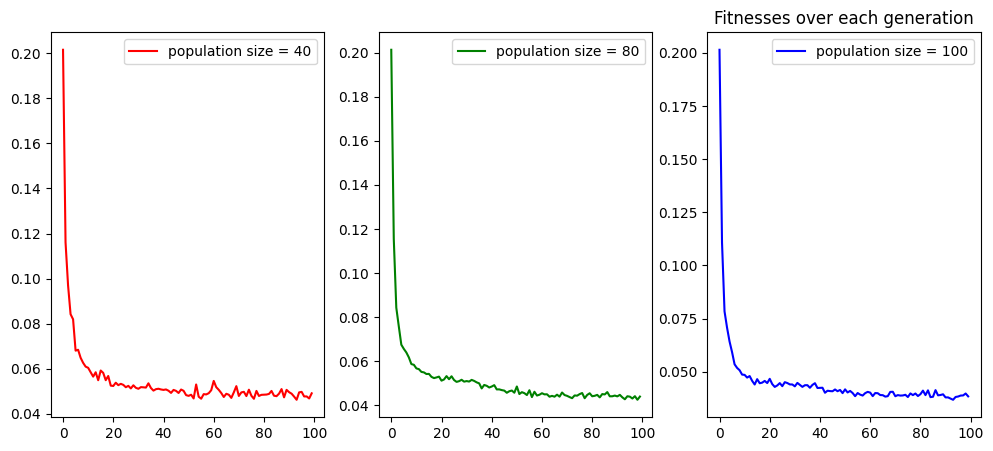

In [27]:
# Create a figure and axis to plot the RGB values
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Plot each RGB value in its own axis
ax[0].plot(fitnesses_mean_1, 'red')
ax[1].plot(fitnesses_mean_2, 'green')
ax[2].plot(fitnesses_mean_3, 'blue')

plt.title("Fitnesses over each generation")
ax[0].legend(["population size = 40"])
ax[1].legend(["population size = 80"])
ax[2].legend(["population size = 100"])
plt.show()

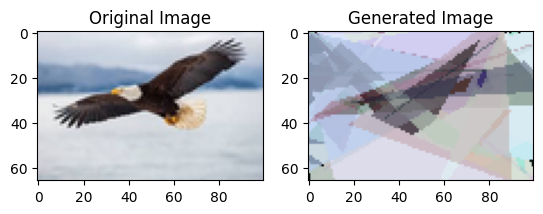

In [34]:
predicted_image = Image.open('best.png')
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(predicted_image)
plt.title('Generated Image')
plt.show()

<h1 style="color:#D40078; font-weight:bold;">Questions:</h1>

<!-- Question 1 -->
<span style="color: blue">1. State space: 100 chromosomes, each with 45 triangles, where each triangle can have 256^4 different colors.</span>
<span style="color: blue">In this case, the state space refers to the set of possible solutions. There are 100 chromosomes, each consisting of 45 triangles. Each triangle can take on \( 256^4 \) different color values, and \( 3^(width*height\) leading to a massive number of possible combinations.</p>

<!-- Question 2 -->
<span style="color: blue">2. Increasing the number of chromosomes in the population can cause faster convergence because it increases diversity.</span>


<!-- Question 3 -->
<span style="color: blue">3. Two strategies for transitioning to the next generation:</span>
<p>
<span style="color: blue">    <strong>Strategy 1: Selection</strong><br>
    In this strategy, chromosomes are selected based on their fitness. The fittest individuals are more likely to be selected for reproduction, ensuring that beneficial traits are passed on. Common selection methods include:<br>
    - <em>Roulette Wheel Selection</em><br>
    - <em>Tournament Selection</em><br>
    - <em>Rank Selection</em><br>
<span style="color: blue">
    <strong>Strategy 2: Crossover</strong><br>
    Crossover involves combining the genetic material of two parent chromosomes to produce offspring for the next generation. This process allows for the exchange of traits between parents, potentially leading to better solutions. Common crossover methods include:<br>
    - <em>Single-Point Crossover</em><br>
    - <em>Two-Point Crossover</em><br>
</p>


<h1 style="color:#D40078; font-weight:bold;">Game:</h1>  



In [39]:
import numpy as np
import random
import pygame
import math
from time import sleep, time

ROW_COUNT = 6
COLUMN_COUNT = 7
SQUARESIZE = 100
RADIUS = int(SQUARESIZE / 2 - 5)
PLAYER = 1
CPU = -1
EMPTY = 0
PLAYER_PIECE = 1
CPU_PIECE = -1
BLUE = (0, 0, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
YELLOW = (255, 255, 0)
WINDOW_LENGTH = 4
WINING_SCORE = 10000000000000

pygame 2.6.1 (SDL 2.28.4, Python 3.12.7)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [40]:
class Connect4UI:
    def __init__(self, width=COLUMN_COUNT*SQUARESIZE, height=(ROW_COUNT+1)*SQUARESIZE):
        pygame.init()
        self.width = width
        self.height = height
        self.size = (self.width, self.height)
        self.screen = pygame.display.set_mode(self.size)
        self.font = pygame.font.SysFont("monospace", 75)

    def draw_board(self, board):
        for c in range(COLUMN_COUNT):
            for r in range(ROW_COUNT):
                pygame.draw.rect(self.screen, BLUE, (c * SQUARESIZE, r * SQUARESIZE + SQUARESIZE, SQUARESIZE, SQUARESIZE))
                pygame.draw.circle(self.screen, BLACK, (int(c * SQUARESIZE + SQUARESIZE / 2), int(r * SQUARESIZE + SQUARESIZE + SQUARESIZE / 2)), RADIUS)

        for c in range(COLUMN_COUNT):
            for r in range(ROW_COUNT):
                if board[r][c] == PLAYER_PIECE:
                    pygame.draw.circle(self.screen, RED, (int(c * SQUARESIZE + SQUARESIZE / 2), self.height - int(r * SQUARESIZE + SQUARESIZE / 2)), RADIUS)
                elif board[r][c] == CPU_PIECE:
                    pygame.draw.circle(self.screen, YELLOW, (int(c * SQUARESIZE + SQUARESIZE / 2), self.height - int(r * SQUARESIZE + SQUARESIZE / 2)), RADIUS)

        pygame.display.update()
        sleep(0.2)
        

    def display_winner(self, winner):
        if winner == PLAYER:
            label = self.font.render("Player wins!!", 1, RED)
        elif winner == CPU:
            label = self.font.render("Computer wins!!", 1, YELLOW)
        else:
            label = self.font.render("It's a draw!!", 1, BLUE)
        self.screen.blit(label, (40, 10))
        pygame.display.update()
        sleep(5)

In [55]:
class Connect4Game:
    def __init__(self, ui, minimax_depth=1, prune=True):
        self.board = np.zeros((ROW_COUNT, COLUMN_COUNT))
        self.ui = Connect4UI() if ui else None
        self.minimax_depth = minimax_depth
        self.prune = prune
        self.current_turn = random.choice([1, -1])
        
    def drop_piece(self, board, row, col, piece):
        board[row][col] = piece

    def get_next_open_row(self, board,col):
        for r in range(ROW_COUNT):
            if board[r][col] == 0:
                return r

    def print_board(self, board):
        print(np.flip(board, 0))
        print("\n")


    def winning_move(self, board, piece):
        for c in range(COLUMN_COUNT - 3):
            for r in range(ROW_COUNT):
                if all(board[r][c+i] == piece for i in range(WINDOW_LENGTH)):
                    return True

        for c in range(COLUMN_COUNT):
            for r in range(ROW_COUNT - 3):
                if all(board[r+i][c] == piece for i in range(WINDOW_LENGTH)):
                    return True

        for c in range(COLUMN_COUNT - 3):
            for r in range(ROW_COUNT - 3):
                if all(board[r+i][c+i] == piece for i in range(WINDOW_LENGTH)):
                    return True

        for c in range(COLUMN_COUNT - 3):
            for r in range(3, ROW_COUNT):
                if all(board[r-i][c+i] == piece for i in range(WINDOW_LENGTH)):
                    return True

        return False
    
    def evaluate_window(self, window, piece):
        score = 0
        opp_piece = PLAYER_PIECE
        if piece == PLAYER_PIECE:
            opp_piece = CPU_PIECE
        
        if window.count(piece) == 4:
            score += 100
        elif window.count(piece) == 3 and window.count(EMPTY) == 1:
            score += 5
        elif window.count(piece) == 2 and window.count(EMPTY) == 2:
            score += 2
        if window.count(opp_piece) == 3 and window.count(EMPTY) == 1:
            score -= 4
        
        return score
    
    def score_position(self, board, piece):
        score = 0  
        center_array = [int(i) for i in list(board[:, COLUMN_COUNT//2])]
        center_count = center_array.count(piece)
        score += center_count * 3
    
        for r in range(ROW_COUNT):
            row_array = [int(i) for i in list(board[r,:])]
            for c in range(COLUMN_COUNT-3):
                window = row_array[c:c+WINDOW_LENGTH]
                score += self.evaluate_window(window, piece)

        for c in range(COLUMN_COUNT):
            col_array = [int(i) for i in list(board[:,c])]
            for r in range(ROW_COUNT-3):
                window = col_array[r:r+WINDOW_LENGTH]
                score += self.evaluate_window(window, piece)

        for r in range(ROW_COUNT-3):
            for c in range(COLUMN_COUNT-3):
                window = [board[r+i][c+i] for i in range(WINDOW_LENGTH)]
                score += self.evaluate_window(window, piece)
                
        for r in range(ROW_COUNT-3):
            for c in range(COLUMN_COUNT-3):
                window = [board[r+3-i][c+i] for i in range(WINDOW_LENGTH)]
                score += self.evaluate_window(window, piece)
    
        return score
    
    def is_terminal_node(self, board):
        return self.winning_move(board, PLAYER_PIECE) or self.winning_move(board, CPU_PIECE) or len(self.get_valid_locations(board)) == 0
    
    def get_valid_locations(self, board):
        valid_locations = []
        for col in range(COLUMN_COUNT):
            if board[ROW_COUNT-1][col] == 0:
                valid_locations.append(col)
        return valid_locations
    
    def best_cpu_score(self, board, moves):
        move = None
        max_score = -math.inf
        for col in moves:
            row = self.get_next_open_row(board, col)
            b_copy = board.copy()
            self.drop_piece(b_copy, row, col, CPU_PIECE)
            score = self.heuristic(b_copy, CPU_PIECE)
            if score > max_score:
                max_score = score
                move = col
        return move
    
    def heuristic(self, board, piece):
        if(self.is_terminal_node(board)):
            if self.winning_move(board, piece):
                return WINING_SCORE
            elif self.winning_move(board, -piece):
                return -WINING_SCORE
            else:
                return 0
        else:
            return self.score_position(board, piece) - self.score_position(board, -piece)



 

    def minimax(self, board, depth, alpha, beta, player):
        valid_locations = self.get_valid_locations(board)
        if depth == 0 or self.is_terminal_node(board):
            return None, self.heuristic(board, player)


        if player == PLAYER_PIECE:
            max_val = -math.inf
            column = random.choice(valid_locations)
            for col in valid_locations :
                new_board = board.copy()
                self.drop_piece(new_board, self.get_next_open_row(new_board, col), col, PLAYER_PIECE)
                _, new_score = self.minimax(new_board, depth - 1, alpha, beta, CPU_PIECE)
                if new_score > max_val:
                    value = new_score
                    column = col
                    
                    if self.prune == True:
                        alpha = max(alpha, value)
                        if alpha >= beta:
                            break
            return column, value
        else:
            min_val = math.inf
            column = random.choice(valid_locations)
            for col in valid_locations:    
                new_board = board.copy()
                self.drop_piece(new_board, self.get_next_open_row(new_board, col), col, CPU_PIECE)
                _, new_score = self.minimax(new_board, depth - 1, alpha, beta, PLAYER_PIECE)
                if new_score < min_val:
                    value = new_score
                    column = col
                    if self.prune == True:
                        beta = min(beta, value)
                        if alpha >= beta:
                            break
        return column, value


    def get_cpu_move(self, board, randomness_percent=30):
        moves = self.get_valid_locations(board)
        if len(moves) == 0:
            return None
        random_move = random.choice(moves)
        score_move = self.best_cpu_score(board, moves)
        move = random.choice([score_move] * (100 - randomness_percent) + [random_move] * randomness_percent)
        return move, self.get_next_open_row(board, move)


    def get_human_move(self, board, depth = 1):
        col = self.minimax(board, depth, -math.inf, math.inf, self.current_turn)[0]
        return col, self.get_next_open_row(board, col)

    def play(self):
        winner = None
        while not self.is_terminal_node(self.board):
            if self.ui:
                self.ui.draw_board(self.board)
            if self.current_turn == PLAYER:
                col, row = self.get_human_move(self.board, self.minimax_depth)
                if col is not None:
                    self.drop_piece(self.board, row, col, PLAYER_PIECE)
                    if self.winning_move(self.board, PLAYER_PIECE):
                        winner = PLAYER
                    self.current_turn = CPU
                    #self.print_board(self.board)

            else:
                col, row = self.get_cpu_move(self.board)
                
                if col is not None:
                    self.drop_piece(self.board, row, col, CPU_PIECE)
                    if self.winning_move(self.board, CPU_PIECE):
                        winner = CPU
                    self.current_turn = PLAYER
                    #self.print_board(self.board)
            
            if self.ui:
                self.ui.draw_board(self.board)
                if winner is not None:
                    self.ui.display_winner(winner)
                            
        if winner is None:
            winner = 0
        return winner

Complete the Connect4Game class below by implementing the `minimax algorithm` with `alpha-beta pruning` and `depth limiting`. Don't change other parts of the code unless you want to define a new heuristic function.

In [56]:
def print_results(results, depth, pruning, start, end):
    pruning_status = "Enabled" if pruning else "Disabled"
    print(
        f'Depth: {depth} | Pruning: {pruning_status} -> User Wins: {results[1]:3}, CPU Wins: {results[-1]:2}, Ties: {results[0]:2}, Time: {end - start:.2f}s'
    )

Use the code below to test the game with the UI. Pygame is not compatible with Jupyter Notebook and will not work in this environment. To use Pygame, please run the code in a separate `.py` file.

In [57]:
game = Connect4Game(True, 3, False)
game.play()

-1

\un the following code to test the results of the game and the time taken to play the game in different `depths` and with `pruning` enabled and disabled.

In [60]:
def check_results():
    for pruning in [True, False]:  
        for d in range(1, 4):
            results = {-1: 0, 0: 0, 1: 0}
            start = time()
            for _ in range(20):  
                game = Connect4Game(False, d, pruning)  
                results[game.play()] += 1
            end = time()
            print_results(results, d, pruning, start, end)

check_results()

Depth: 1 | Pruning: Enabled -> User Wins:  12, CPU Wins:  8, Ties:  0, Time: 0.31s
Depth: 2 | Pruning: Enabled -> User Wins:  13, CPU Wins:  7, Ties:  0, Time: 0.53s
Depth: 3 | Pruning: Enabled -> User Wins:  14, CPU Wins:  6, Ties:  0, Time: 1.43s
Depth: 1 | Pruning: Disabled -> User Wins:   8, CPU Wins: 12, Ties:  0, Time: 0.30s
Depth: 2 | Pruning: Disabled -> User Wins:  11, CPU Wins:  9, Ties:  0, Time: 1.12s
Depth: 3 | Pruning: Disabled -> User Wins:  12, CPU Wins:  8, Ties:  0, Time: 6.76s


<h1 style="color:#D40078; font-weight:bold;">Questions:</h1>
<span style="color: blue"> 1. Increasing the depth can improve the chances of winning because it allows us to see many states in our tree, enabling better decision-making. However, it also takes more time.</span>  

<span style="color: blue">2.No, changing the order of visiting child nodes to achieve maximum pruning is not practical, as it requires a lot of time and is not efficient in practice.</span>  
<span style="color: blue"> 3. The branching factor in computing, tree data structures, and game theory refers to the number of children at each node, also known as the outdegree. When the number of children per node isn't uniform across the tree or graph, an average branching factor is calculated to represent the typical case. I think as we move deeper into the game, the branching factor decreases.</span>  

<span style="color: blue"> 4. Pruning eliminates unnecessary nodes or branches in decision trees that don't contribute much to the model's predictive power. This helps reduce the complexity of our models.</span>  
<span style="color: blue"> 5. 5. When our agent is not rational and decides randomly, it can miss advantageous states in a strategic game. In such cases, instead of using minimax, we should use the expectimax algorithm to consider the average outcome.</span> 